# Natality project: predictive analysis #
(classification continued)

This is the continuation of the Machine Learning section of the Natality project. See details and other parts on [Github](https://github.com/bd3thier/Natality-project).


In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn import metrics

In [2]:
# Import catboost package
import catboost as cb
import catboost.utils as cbu
import hyperopt

### 5. Catboost

Catboost can deal with missing values, so we want to test its capabilities on the non-imputed dataset. Furthermore, the dataset doesn't need to be dummified or log-transformed.

In [3]:
# Load dataset
data = pd.read_csv('data/df_raw_nona_42.csv', index_col=0)
data.head()

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,birth_month,birth_time,birth_weekday,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,...,no_maternal_morbidity,payment,plural_birth,sex,gestation_week,obstetric_estimate,birth_weight,no_abnormal_condition,no_congenital_anomalies,breastfed
1,1,1227.0,2,1.0,30,1,1,0.0,X,6.0,...,1.0,2.0,1,M,38.0,40.0,3657.0,1.0,1.0,Y
2,1,1704.0,2,1.0,35,1,3,0.0,Y,NaN,...,1.0,1.0,1,F,39.0,39.0,3242.0,0.0,1.0,Y
3,1,336.0,2,1.0,28,1,1,0.0,X,6.0,...,1.0,4.0,1,M,37.0,36.0,3470.0,1.0,1.0,Y
4,1,938.0,2,1.0,23,1,3,0.0,Y,2.0,...,1.0,1.0,1,F,31.0,39.0,3140.0,1.0,1.0,N
5,1,830.0,3,1.0,37,1,1,0.0,X,4.0,...,1.0,1.0,1,M,37.0,37.0,2125.0,0.0,1.0,Y


In [4]:
# Keep only spontaneous births
df = data[data.obstetric_estimate.notna()]
df = df[df.induction == 'N']
df = df[(df.labor_trial == 'Y')  | (df.delivery_method == 1)]

df.shape

(1919518, 42)

In [5]:
# Create label column
df['premature'] = df.obstetric_estimate.between(0, 36)
df=df.drop('obstetric_estimate', axis = 1)

In [6]:
#Remove columns not used for prediction:  
df.drop(['father_age','BMI','birth_weekday','number_prenatal_visits', 'delivery_method', 'breastfed', 
           'no_abnormal_condition', 'no_maternal_morbidity', 'birth_weight', 'birth_time', 'delivery_weight', 
           'labor_trial', 'no_congenital_anomalies', 'gestation_week', 'induction', 'labor_trial'], inplace=True, axis =1)
df.head()

,birth_month,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,father_race,father_hispanic,...,prepregnancy_weight,previous_preterm_birth,infertility_treatment,previous_cesareans,no_risk_factors,no_infection,payment,plural_birth,sex,premature
1,1,1.0,30,1,1,0.0,X,6.0,1,1,...,190.0,N,N,0.0,1.0,1.0,2.0,1,M,False
3,1,1.0,28,1,1,0.0,X,6.0,1,0,...,215.0,N,N,0.0,0.0,1.0,4.0,1,M,True
4,1,1.0,23,1,3,0.0,Y,2.0,3,0,...,138.0,N,N,0.0,1.0,1.0,1.0,1,F,False
6,1,2.0,26,1,1,0.0,X,6.0,1,6,...,200.0,N,N,0.0,1.0,1.0,2.0,1,F,False
8,1,1.0,31,1,1,0.0,X,3.0,1,0,...,180.0,N,N,0.0,1.0,1.0,2.0,1,F,False


### Setup Catboost###

In [7]:
X = df.drop('premature', axis=1)
y = df.premature.astype(int)

In [8]:
numeric = ['mother_age', 'total_birth_order', 'interval_since_last_pregnancy', 
           'month_prenatal_care_began', 'mother_height', 'prepregnancy_weight', 
           'previous_cesareans', 'plural_birth']

In [9]:
categorical = ['birth_month', 'birth_place', 'mother_nativity', 'mother_race', 'mother_hispanic', 'paternity_acknowledged',
               'mother_education', 'father_race', 'father_hispanic', 'father_education', 'WIC', 'tobacco', 
               'previous_preterm_birth', 'infertility_treatment','no_risk_factors', 'no_infection',
                'payment', 'sex']

In [10]:
X[categorical] = X[categorical].astype(str)

In [11]:
X.dtypes

birth_month                       object
birth_place                       object
mother_age                         int64
mother_nativity                   object
mother_race                       object
mother_hispanic                   object
paternity_acknowledged            object
mother_education                  object
father_race                       object
father_hispanic                   object
father_education                  object
total_birth_order                float64
interval_since_last_pregnancy    float64
month_prenatal_care_began        float64
WIC                               object
tobacco                           object
mother_height                    float64
prepregnancy_weight              float64
previous_preterm_birth            object
infertility_treatment             object
previous_cesareans               float64
no_risk_factors                   object
no_infection                      object
payment                           object
plural_birth    

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 2, stratify = y)

In [13]:
from catboost import CatBoostClassifier, Pool, cv

In [14]:
cat_features = [X.columns.get_loc(i) for i in categorical]
cat_features

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 18, 19, 21, 22, 23, 25]

In [15]:
X.shape

(1919518, 26)

### Hyperparameter tuning
The following code was inspired by the tutorial on [Catboost github](https://github.com/catboost/tutorials/blob/master/classification/classification_with_parameter_tuning_tutorial.ipynb).

In [16]:
class ClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            #'subsample':  hyper_params['subsample'],
            'bagging_temperature': hyper_params['bagging_temperature'],
            'random_strength': hyper_params['random_strength'],
            'one_hot_max_size': hyper_params['one_hot_max_size'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params))#, file=sys.stdout)
        #sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=20181224,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        max_mean_auc = np.max(scores['test-AUC-mean'])
        print('evaluated score={}'.format(max_mean_auc))#, file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count))#, file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -max_mean_auc, 'status': hyperopt.STATUS_OK}

In [17]:
def find_best_hyper_params(dataset, const_params, max_evals=1000):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-7, 1.0),
        'depth': hyperopt.hp.quniform('depth', 2, 10, 1),
        #'subsample':  hyperopt.hp.uniform('subsample', 0.5, 1.0),
        'bagging_temperature': hyperopt.hp.uniform('bagging_temperature', 0, 1.0),
        'random_strength': hyperopt.hp.quniform('random_strength', 1, 20, 1),
        'one_hot_max_size': hyperopt.hp.quniform('one_hot_max_size', 2, 25, 1),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 100)}
    objective = ClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=20181224))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=cat_features)
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [19]:
# make it True if your want to use GPU for training
have_gpu = True

# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False

# number of iterations of hyper-parameter search
hyperopt_iterations = 10

const_params = dict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 1000,
    'class_weights': (1, 11.05),
    'random_seed': 20181224})

model, params = train_best_model(
    X_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params))

evaluating params={'learning_rate': 0.037876849203502025, 'depth': 9.0, 'bagging_temperature': 0.47918640562461323, 'random_strength': 16.0, 'one_hot_max_size': 22.0, 'l2_leaf_reg': 9.1985211102147, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 1000, 'class_weights': (1, 11.05), 'random_seed': 20181224}
evaluated score=0.7325413177410761                    
evaluated 1 times                                     
evaluating params={'learning_rate': 0.0199546385011469, 'depth': 6.0, 'bagging_temperature': 0.9872475700965786, 'random_strength': 16.0, 'one_hot_max_size': 9.0, 'l2_leaf_reg': 27.28326114772857, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 1000, 'class_weights': (1, 11.05), 'random_seed': 20181224}
evaluated score=0.7302997807661692                                                   
evaluated 2 times                                                   

Shortcut to train a model without optimization:

In [22]:
model = CatBoostClassifier(
    iterations = 2000,
    learning_rate = 0.17776794583783415,
    depth = 4,
    bagging_temperature = 0.4377675530708244,
    one_hot_max_size = 16,
    l2_leaf_reg= 74.89390489057426,
    random_strength= 11.0,
    loss_function = 'Logloss',
    verbose = 20, 
    task_type = 'GPU',
    class_weights= (1, 11.05)
)
model.fit(X_train, y = y_train, cat_features=cat_features,
          eval_set = (X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6687254	test: 0.6687612	best: 0.6687612 (0)	total: 11.3ms	remaining: 22.6s
20:	learn: 0.6107726	test: 0.6112231	best: 0.6112231 (20)	total: 232ms	remaining: 21.9s
40:	learn: 0.6038967	test: 0.6044551	best: 0.6044551 (40)	total: 459ms	remaining: 21.9s
60:	learn: 0.6008118	test: 0.6014476	best: 0.6014476 (60)	total: 677ms	remaining: 21.5s
80:	learn: 0.5987349	test: 0.5995752	best: 0.5995752 (80)	total: 898ms	remaining: 21.3s
100:	learn: 0.5974132	test: 0.5983373	best: 0.5983373 (100)	total: 1.12s	remaining: 21.1s
120:	learn: 0.5963889	test: 0.5974634	best: 0.5974634 (120)	total: 1.34s	remaining: 20.8s
140:	learn: 0.5956028	test: 0.5968264	best: 0.5968264 (140)	total: 1.56s	remaining: 20.6s
160:	learn: 0.5949617	test: 0.5964163	best: 0.5964163 (160)	total: 1.79s	remaining: 20.4s
180:	learn: 0.5943825	test: 0.5960509	best: 0.5960509 (180)	total: 2s	remaining: 20.1s
200:	learn: 0.5939324	test: 0.5957965	best: 0.5957965 (200)	total: 2.22s	remaining: 19.9s
220:	learn: 0.5934970	te

1840:	learn: 0.5789059	test: 0.5957126	best: 0.5945479 (639)	total: 20.6s	remaining: 1.77s
1860:	learn: 0.5787606	test: 0.5957408	best: 0.5945479 (639)	total: 20.8s	remaining: 1.55s
1880:	learn: 0.5786154	test: 0.5957512	best: 0.5945479 (639)	total: 21s	remaining: 1.33s
1900:	learn: 0.5784863	test: 0.5957886	best: 0.5945479 (639)	total: 21.2s	remaining: 1.1s
1920:	learn: 0.5783434	test: 0.5957890	best: 0.5945479 (639)	total: 21.4s	remaining: 882ms
1940:	learn: 0.5782048	test: 0.5958336	best: 0.5945479 (639)	total: 21.7s	remaining: 659ms
1960:	learn: 0.5780671	test: 0.5958901	best: 0.5945479 (639)	total: 21.9s	remaining: 436ms
1980:	learn: 0.5779324	test: 0.5959240	best: 0.5945479 (639)	total: 22.1s	remaining: 212ms
1999:	learn: 0.5777992	test: 0.5959539	best: 0.5945479 (639)	total: 22.3s	remaining: 0us
bestTest = 0.594547863
bestIteration = 639
Shrink model to first 640 iterations.


In [23]:
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    
    dataset = cb.Pool(X, y, cat_features=cat_features)
    fpr, tpr, _ = cbu.get_roc_curve(model, dataset, plot=True)
    auc = sklearn.metrics.auc(fpr, tpr)
    return auc

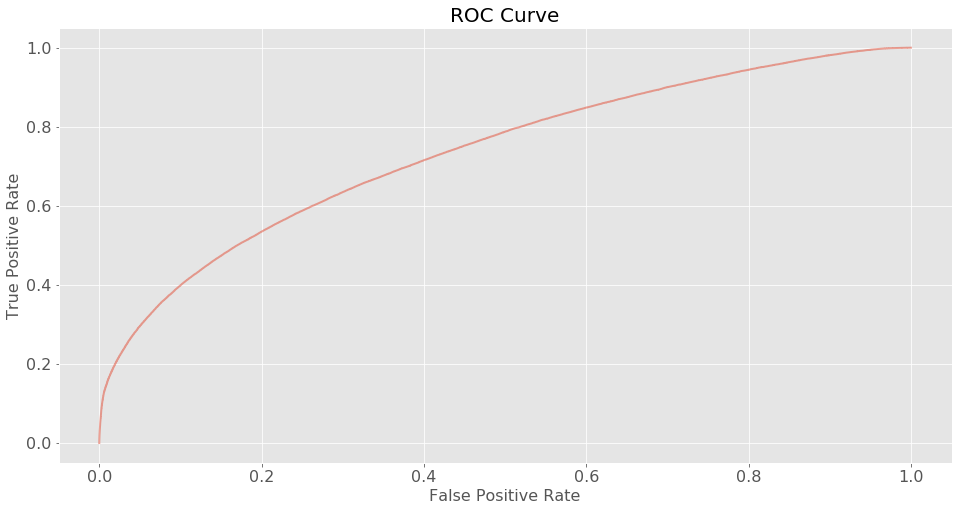

0.7338122076177623

In [24]:
calculate_score_on_dataset_and_show_graph(X_test, y_test, model)

In [25]:
# Prediction test labels
predictions = model.predict(X_test)

Catboost (optimized) confusion matrix:  [[398621 129288]
 [ 20006  27941]]


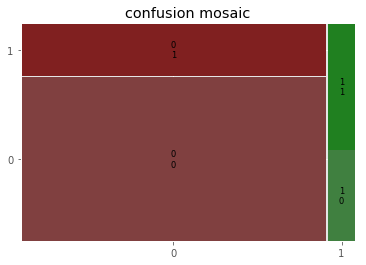

In [26]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('Catboost (optimized) confusion matrix: ', confusion_matrix)

from statsmodels.graphics.mosaicplot import mosaic
mosaic(confusion_matrix, title= 'confusion mosaic')
plt.show()

In [27]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.178
Recall : 0.583
Accuracy :  0.741


### Feature selection to improve the model

Select features cumulating to 95% importance. We will use the PredictionValuesChange type of importance from Catboost (see also [article on other types](https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed))

In [28]:
model.get_feature_importance(prettified=True, type = 'PredictionValuesChange')

,Feature Id,Importances
0,plural_birth,40.568891
1,no_risk_factors,8.737982
2,month_prenatal_care_began,8.400738
3,interval_since_last_pregnancy,6.394583
4,birth_place,5.813448
5,previous_preterm_birth,5.034067
6,prepregnancy_weight,2.965961
7,father_education,2.576423
8,paternity_acknowledged,2.229165
9,mother_age,2.012215


In [29]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, 
                                      model.get_feature_importance(Pool(X, label=y, 
                                                                        cat_features=cat_features)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', 
                                          na_position='last')

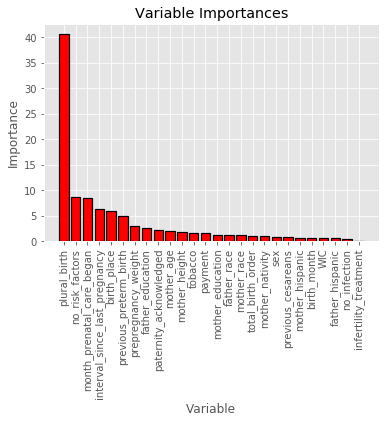

In [30]:
# list of x locations for plotting
x_values = list(range(len(feature_score)))
# Make a bar chart
plt.bar(x_values, feature_score['Score'], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_score['Feature'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

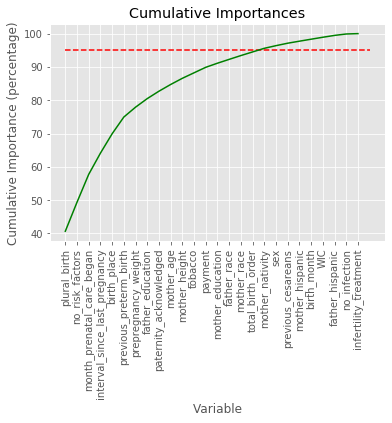

In [31]:
# Cumulative importances
cumulative_importances = np.cumsum(feature_score['Score'])
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(feature_score['Score']), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, feature_score['Feature'], rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance (percentage)'); plt.title('Cumulative Importances');

In [32]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
threshold= np.where(cumulative_importances > 95)[0][0] + 1
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 18


In [33]:
# List of features for later use
feature_list = list(X.columns)
# Extract the names of the most important features
important_feature_names = feature_score[0:threshold]['Feature']
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_X_train = X_train.iloc[:, important_indices]
important_X_test = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_X_train.shape)
print('Important test features shape:', important_X_test.shape)

Important train features shape: (1343662, 18)
Important test features shape: (575856, 18)


In [34]:
num_cols = important_X_train._get_numeric_data().columns
cols = important_X_train.columns
important_cat_features = list(set(cols) - set(num_cols))
important_cat_features

['tobacco',
 'payment',
 'previous_preterm_birth',
 'mother_race',
 'birth_place',
 'paternity_acknowledged',
 'father_race',
 'father_education',
 'mother_nativity',
 'no_risk_factors',
 'mother_education']

In [35]:
cat_features = [important_X_train.columns.get_loc(i) for i in important_cat_features]
cat_features

[11, 12, 5, 15, 4, 8, 14, 7, 17, 1, 13]

In [36]:
# make it True if your want to use GPU for training
have_gpu = True

# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False

# number of iterations of hyper-parameter search
hyperopt_iterations = 10

const_params = dict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 1000,
    'class_weights': (1, 0.0905),
    'random_seed': 20181224})

model2, params = train_best_model(
    important_X_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params))

evaluating params={'learning_rate': 0.037876849203502025, 'depth': 9.0, 'bagging_temperature': 0.47918640562461323, 'random_strength': 16.0, 'one_hot_max_size': 22.0, 'l2_leaf_reg': 9.1985211102147, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 1000, 'class_weights': (1, 0.0905), 'random_seed': 20181224}
evaluated score=0.7279569158951441                    
evaluated 1 times                                     
evaluating params={'learning_rate': 0.0199546385011469, 'depth': 6.0, 'bagging_temperature': 0.9872475700965786, 'random_strength': 16.0, 'one_hot_max_size': 9.0, 'l2_leaf_reg': 27.28326114772857, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 1000, 'class_weights': (1, 0.0905), 'random_seed': 20181224}
evaluated score=0.7236742178599039                                                   
evaluated 2 times                                                 

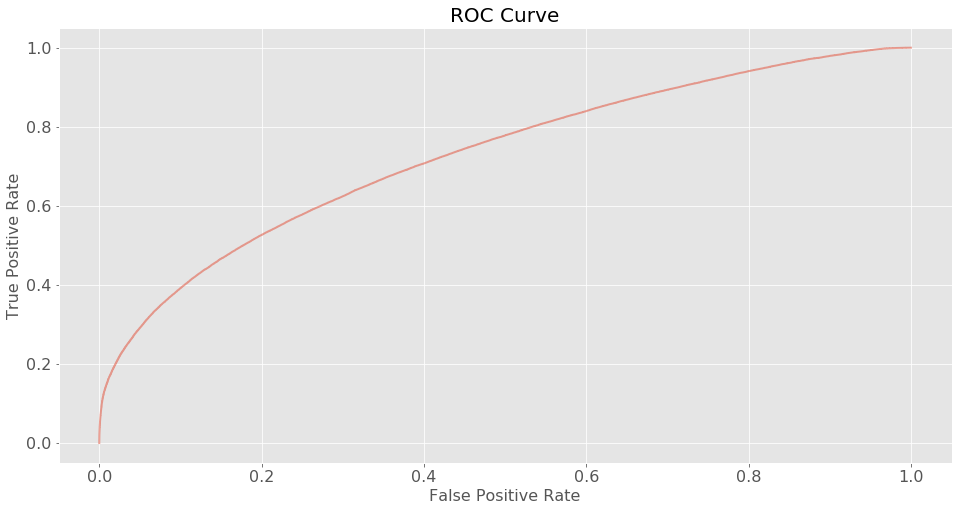

0.7277297390181576

In [37]:
calculate_score_on_dataset_and_show_graph(important_X_test, y_test, model2)

In [38]:
# Prediction test labels
predictions = model2.predict(important_X_test)

Catboost (optimized) confusion matrix:  [[527886     23]
 [ 47394    553]]


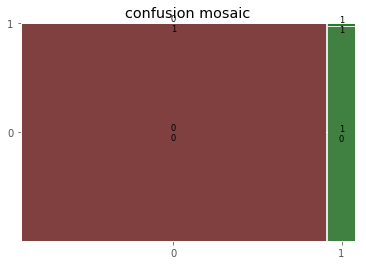

In [39]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('Catboost (optimized) confusion matrix: ', confusion_matrix)

from statsmodels.graphics.mosaicplot import mosaic
mosaic(confusion_matrix, title= 'confusion mosaic')
plt.show()

In [40]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.960
Recall : 0.012
Accuracy :  0.918


### Standardize numeric features 

We need to standardize the numeric features only:

In [52]:
from sklearn.preprocessing import StandardScaler
standardized_X_train = X_train.copy()
features = standardized_X_train[numeric]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
standardized_X_train[numeric] = features
standardized_X_train.head()

,birth_month,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,father_race,father_hispanic,...,mother_height,prepregnancy_weight,previous_preterm_birth,infertility_treatment,previous_cesareans,no_risk_factors,no_infection,payment,plural_birth,sex
1561668,1,1.0,0.969386,1,1,0.0,X,6.0,1,0,...,-0.390914,-0.467583,N,N,-0.199838,1.0,1.0,2.0,-0.117382,F
1233500,4,1.0,0.969386,2,1,0.0,X,6.0,1,0,...,1.028755,-0.735290,N,N,-0.199838,1.0,1.0,1.0,-0.117382,M
2178958,12,1.0,0.268379,1,1,0.0,X,6.0,1,0,...,1.738590,-0.467583,N,N,-0.199838,0.0,1.0,2.0,-0.117382,F
1455910,2,1.0,-0.958382,1,1,0.0,Y,3.0,9,9,...,-0.745832,-0.333730,N,N,-0.199838,1.0,1.0,1.0,-0.117382,F
2901037,3,1.0,-0.607878,1,1,0.0,Y,3.0,1,0,...,-0.035997,1.540214,N,N,-0.199838,1.0,1.0,2.0,-0.117382,F


In [53]:
standardized_X_test = X_test.copy()
features = standardized_X_test[numeric]
features = scaler.transform(features.values)
standardized_X_test[numeric] = features
standardized_X_test.head()

,birth_month,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,father_race,father_hispanic,...,mother_height,prepregnancy_weight,previous_preterm_birth,infertility_treatment,previous_cesareans,no_risk_factors,no_infection,payment,plural_birth,sex
1191409,1,1.0,0.618883,1,1,0.0,X,5.0,1,0,...,-0.745832,-1.136849,N,N,-0.199838,1.0,1.0,3.0,-0.117382,F
1203036,2,1.0,2.546650,2,4,0.0,X,6.0,1,0,...,-1.810584,-1.484867,N,N,3.655342,0.0,1.0,1.0,-0.117382,F
394101,6,1.0,0.268379,2,1,4.0,nan,8.0,1,4,...,-0.390914,-0.815601,N,N,-0.199838,1.0,1.0,2.0,-0.117382,M
1803508,11,1.0,-0.432627,1,1,0.0,N,4.0,9,9,...,2.803343,1.192196,N,N,-0.199838,1.0,1.0,2.0,-0.117382,F
3482927,10,1.0,-0.257375,1,2,0.0,N,4.0,9,9,...,-0.390914,2.182709,N,N,-0.199838,0.0,1.0,1.0,-0.117382,F


In [54]:
cat_features = [X.columns.get_loc(i) for i in categorical]
cat_features

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 18, 19, 21, 22, 23, 25]

In [55]:
standardized_pool = Pool(standardized_X_train, y_train, cat_features=cat_features)

In [62]:
std_model = CatBoostClassifier(
    bagging_temperature= 0.47918640562461323, 
    depth= 9.0, 
    l2_leaf_reg= 9.1985211102147, 
    learning_rate= 0.037876849203502025, 
    one_hot_max_size= 22.0, 
    random_strength= 16.0, 
    eval_metric= 'AUC', 
    class_weights= (1, 0.0905), 
    random_seed= 20181224,
    iterations = 5000,
    loss_function = 'Logloss',
    verbose = 20, 
    task_type = 'GPU'
)

In [63]:
std_model.fit(standardized_pool,
          eval_set = (standardized_X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6586805	test: 0.6579813	best: 0.6579813 (0)	total: 27.6ms	remaining: 2m 17s
20:	learn: 0.6988377	test: 0.6987571	best: 0.6987571 (20)	total: 591ms	remaining: 2m 20s
40:	learn: 0.7063785	test: 0.7059735	best: 0.7059735 (40)	total: 1.18s	remaining: 2m 22s
60:	learn: 0.7126448	test: 0.7120322	best: 0.7120322 (60)	total: 1.76s	remaining: 2m 22s
80:	learn: 0.7162094	test: 0.7156972	best: 0.7156972 (80)	total: 2.36s	remaining: 2m 23s
100:	learn: 0.7175836	test: 0.7168587	best: 0.7168587 (100)	total: 2.94s	remaining: 2m 22s
120:	learn: 0.7195782	test: 0.7186668	best: 0.7186823 (117)	total: 3.54s	remaining: 2m 22s
140:	learn: 0.7216060	test: 0.7207065	best: 0.7207065 (140)	total: 4.15s	remaining: 2m 22s
160:	learn: 0.7233437	test: 0.7222446	best: 0.7222446 (160)	total: 4.75s	remaining: 2m 22s
180:	learn: 0.7246124	test: 0.7233911	best: 0.7233911 (180)	total: 5.34s	remaining: 2m 22s
200:	learn: 0.7257141	test: 0.7243881	best: 0.7243881 (200)	total: 5.94s	remaining: 2m 21s
220:	learn

1800:	learn: 0.7394094	test: 0.7327877	best: 0.7327894 (1796)	total: 48.7s	remaining: 1m 26s
1820:	learn: 0.7394989	test: 0.7327937	best: 0.7327968 (1815)	total: 49.2s	remaining: 1m 25s
1840:	learn: 0.7395765	test: 0.7328062	best: 0.7328062 (1839)	total: 49.8s	remaining: 1m 25s
1860:	learn: 0.7396185	test: 0.7328303	best: 0.7328303 (1860)	total: 50.3s	remaining: 1m 24s
1880:	learn: 0.7396923	test: 0.7328422	best: 0.7328422 (1879)	total: 50.9s	remaining: 1m 24s
1900:	learn: 0.7398027	test: 0.7328579	best: 0.7328580 (1898)	total: 51.4s	remaining: 1m 23s
1920:	learn: 0.7398961	test: 0.7328888	best: 0.7328888 (1920)	total: 52s	remaining: 1m 23s
1940:	learn: 0.7399869	test: 0.7329048	best: 0.7329048 (1939)	total: 52.5s	remaining: 1m 22s
1960:	learn: 0.7400812	test: 0.7329148	best: 0.7329178 (1957)	total: 53s	remaining: 1m 22s
1980:	learn: 0.7401615	test: 0.7329218	best: 0.7329218 (1980)	total: 53.5s	remaining: 1m 21s
2000:	learn: 0.7402292	test: 0.7329254	best: 0.7329288 (1991)	total: 54.1s

3580:	learn: 0.7466389	test: 0.7335380	best: 0.7335513 (3542)	total: 1m 36s	remaining: 38.3s
3600:	learn: 0.7466885	test: 0.7335355	best: 0.7335513 (3542)	total: 1m 37s	remaining: 37.7s
3620:	learn: 0.7467842	test: 0.7335404	best: 0.7335513 (3542)	total: 1m 37s	remaining: 37.2s
3640:	learn: 0.7468849	test: 0.7335372	best: 0.7335513 (3542)	total: 1m 38s	remaining: 36.7s
3660:	learn: 0.7469542	test: 0.7335337	best: 0.7335513 (3542)	total: 1m 38s	remaining: 36.1s
3680:	learn: 0.7470711	test: 0.7335397	best: 0.7335513 (3542)	total: 1m 39s	remaining: 35.6s
3700:	learn: 0.7471567	test: 0.7335385	best: 0.7335513 (3542)	total: 1m 39s	remaining: 35.1s
3720:	learn: 0.7472275	test: 0.7335390	best: 0.7335513 (3542)	total: 1m 40s	remaining: 34.5s
3740:	learn: 0.7472964	test: 0.7335331	best: 0.7335513 (3542)	total: 1m 41s	remaining: 34s
3760:	learn: 0.7473680	test: 0.7335308	best: 0.7335513 (3542)	total: 1m 41s	remaining: 33.5s
3780:	learn: 0.7474616	test: 0.7335463	best: 0.7335513 (3542)	total: 1m 

In [64]:
predictions = std_model.predict(standardized_X_test)

In [72]:
std_model.score(standardized_X_test, y_test)

0.91935310216443

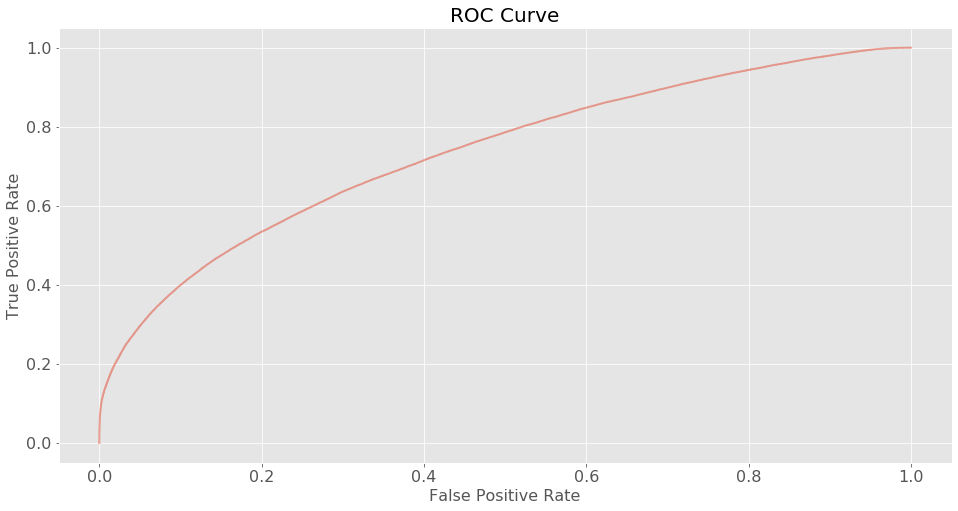

0.7336150251368353

In [73]:
calculate_score_on_dataset_and_show_graph(standardized_X_test, y_test, std_model)

In [69]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.925
Recall : 0.034
Accuracy :  0.919


In [67]:
# Confusion matrix
from catboost.utils import get_confusion_matrix
confusion_matrix = get_confusion_matrix(std_model, standardized_pool)
print('Confusion matrix: ', confusion_matrix)


Confusion matrix:  [[1231786.       0.]
 [ 106825.    5051.]]


In [86]:
# make it True if your want to use GPU for training
have_gpu = True

# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False

# number of iterations of hyper-parameter search
hyperopt_iterations = 10

const_params = dict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 1000,
    'class_weights': (1, 0.0905),
    'random_seed': 20181224})

std_model_tuned, params = train_best_model(
    standardized_X_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params))

evaluating params={'learning_rate': 0.037876849203502025, 'depth': 9.0, 'bagging_temperature': 0.47918640562461323, 'random_strength': 16.0, 'one_hot_max_size': 22.0, 'l2_leaf_reg': 9.1985211102147, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 1000, 'class_weights': (1, 0.0905), 'random_seed': 20181224}
evaluated score=0.7317789047956467                    
evaluated 1 times                                     
evaluating params={'learning_rate': 0.0199546385011469, 'depth': 6.0, 'bagging_temperature': 0.9872475700965786, 'random_strength': 16.0, 'one_hot_max_size': 9.0, 'l2_leaf_reg': 27.28326114772857, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 1000, 'class_weights': (1, 0.0905), 'random_seed': 20181224}
evaluated score=0.7253246257702509                                                   
evaluated 2 times                                                 

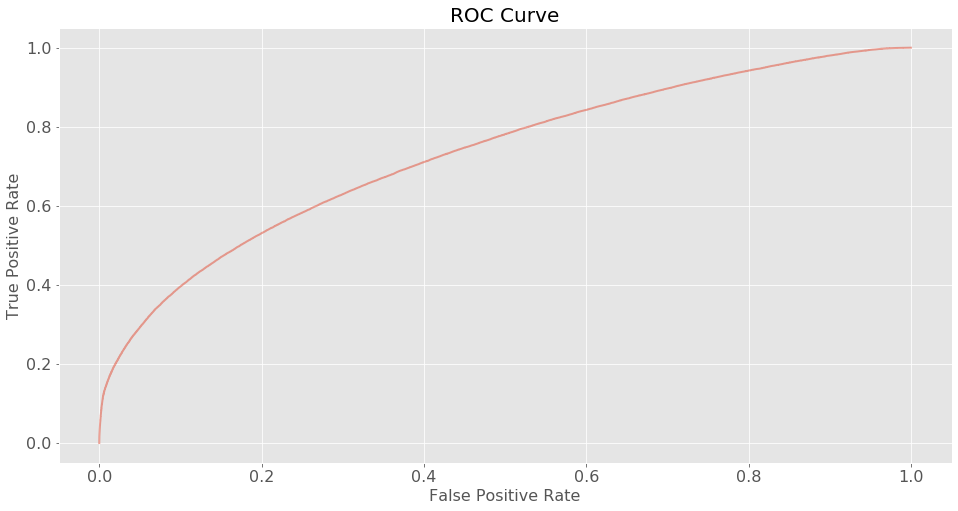

0.7304003760947919

In [87]:
calculate_score_on_dataset_and_show_graph(standardized_X_test, y_test, std_model_tuned)

In [89]:
predictions = std_model_tuned.predict(standardized_X_test)

In [90]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.968
Recall : 0.005
Accuracy :  0.917


Standardization and keeping only features cumulating to 95% of importance led to a very low recall but a higher precision. In our case, we would prefer to have a higher recall - tell too many people they will have a premature baby even if some are wrong - rather than high precision - make less mistake but miss more premature cases.